# Importing libararies

In [1]:
import os
import string

# Data Handling and Processing
import pandas as pd
import numpy as np
import re
from scipy import interp


# Visualuzation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# NLP Packages
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk
from joblib import dump, load


# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier

# Scikit Learn packages
from sklearn.base import clone
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

## Loading Dataset 

In [2]:
business_path = 'bbc/business/'
tech_path = 'bbc/tech/'
arts_path = 'bbc/entertainment/'

In [3]:
text_df = pd.DataFrame(columns=['Text','Class'])
text_df.to_csv('news_df.csv')
text_df.head()

,Text,Class


In [7]:
# Function to read the text files into one dataframe
def readfiles_to_dataframe(directory, category):
    arr = os.listdir(directory)
    strtext = ".txt"
    for textfile in arr:
        if textfile.__contains__(strtext):
            fileObject = open(directory + textfile, "r")
            data = fileObject.read()
            ouvert = pd.read_csv('news_df.csv', index_col="Unnamed: 0")
            ouvert = ouvert.append({"Class": str(category), "Text": data},ignore_index=True)
            ouvert.to_csv('news_df.csv')   

# Define categories             
paths = [business_path, tech_path, arts_path]
categories = ['business', 'tech', 'arts']


# Call readfile function
for path,category in zip(paths, categories):
    readfiles_to_dataframe(path, category)

In [9]:
full_df = pd.read_csv('news_df.csv')
print(full_df.shape)
full_df.head()

(1297, 3)


,Unnamed: 0,Text,Class
0,0,UK economy facing 'major risks'\n\nThe UK manu...,business
1,1,Aids and climate top Davos agenda\n\nClimate c...,business
2,2,Asian quake hits European shares\n\nShares in ...,business
3,3,India power shares jump on debut\n\nShares in ...,business
4,4,Lacroix label bought by US firm\n\nLuxury good...,business


In [10]:
full_df.drop(columns=['Unnamed: 0'], inplace=True)
full_df.head()

,Text,Class
0,UK economy facing 'major risks'\n\nThe UK manu...,business
1,Aids and climate top Davos agenda\n\nClimate c...,business
2,Asian quake hits European shares\n\nShares in ...,business
3,India power shares jump on debut\n\nShares in ...,business
4,Lacroix label bought by US firm\n\nLuxury good...,business


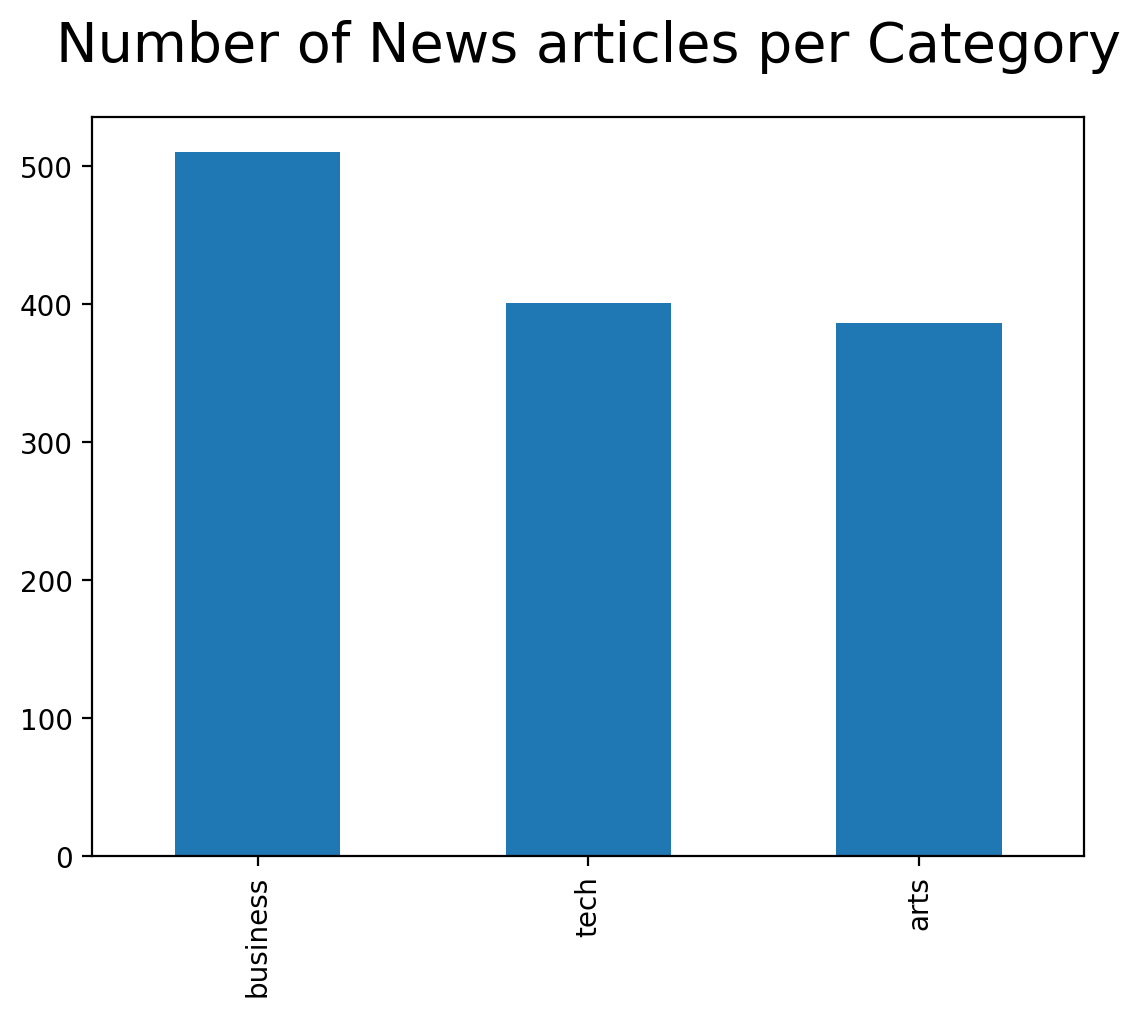

In [11]:
full_df['Class'].value_counts().plot(kind='bar')
plt.title('Number of News articles per Category', size=20, pad=20);

In [12]:
# Check for missing values
full_df.isna().sum()

Text     0
Class    0
dtype: int64

## Text Processing

In [13]:
def preprocess(df):
    # Remove special characters
    df['Text2'] = df['Text'].replace('\n',' ')
    df['Text2'] = df['Text2'].replace('\r',' ')
    
    # Remove punctuation signs and lowercase all
    df['Text2'] = df['Text2'].str.lower()
    df['Text2'] = df['Text2'].str.translate(str.maketrans('', '', string.punctuation))
    
    
    # Remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    
    def fwpt(each):
        tag = pos_tag([each])[0][1][0].upper()
        hash_tag = {"N": wordnet.NOUN,"R": wordnet.ADV, "V": wordnet.VERB,"J": wordnet.ADJ}        
        return hash_tag.get(tag, wordnet.NOUN)

    
    def lematize(text):
        tokens = nltk.word_tokenize(text)
        ax = ""
        for each in tokens:
            if each not in stop_words:
                ax += lemmatizer.lemmatize(each, fwpt(each)) + " "
        return ax
    
    df['Text2'] = df['Text2'].apply(lematize)

In [14]:
preprocess(full_df)

In [15]:
full_df.iloc[1]['Text']

'Aids and climate top Davos agenda\n\nClimate change and the fight against Aids are leading the list of concerns for the first day of the World Economic Forum in the Swiss resort of Davos.\n\nSome 2,000 business and political leaders from around the globe will listen to UK Prime Minister Tony Blair\'s opening speech on Wednesday. Mr Blair will focus on Africa\'s development plans and global warming. Earlier in the day came an update on efforts to have 3 million people on anti-Aids drugs by the end of 2005. The World Health Organisation (WHO) said 700,000 people in poor countries were on life-extending drugs - up from 440,000 six months earlier but amounting to only 12% of the 5.8 million who needed them. A $2bn "funding gap" still stood in the way of hitting the 2005 target, the WHO said.\n\nThe themes to be stressed by Mr Blair - whose attendance was announced at the last minute - are those he wants to dominate the UK\'s chairmanship of the G8 group of industrialised states. Other iss

In [16]:
full_df.iloc[1]['Text2']

'aid climate top davos agenda climate change fight aid lead list concern first day world economic forum swiss resort davos 2000 business political leader around globe listen uk prime minister tony blair opening speech wednesday mr blair focus africa development plan global warm earlier day come update effort 3 million people antiaids drug end 2005 world health organisation say 700000 people poor country lifeextending drug 440000 six month earlier amount 12 58 million need 2bn funding gap still stood way hit 2005 target say theme stress mr blair whose attendance announce last minute want dominate uk chairmanship g8 group industrialise state issue discuss fiveday conference range china economic power iraq future sunday election aside mr blair 20 world leader expect attend include french president jacques chirac due speak video link bad weather delayed helicopter south african president thabo mbeki whose arrival delayed ivory coast peace talk ukraine new president viktor yushchenko also n

## Train test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(full_df['Text2'], 
                                                    full_df['Class'], 
                                                    test_size=0.2, 
                                                    random_state=9)

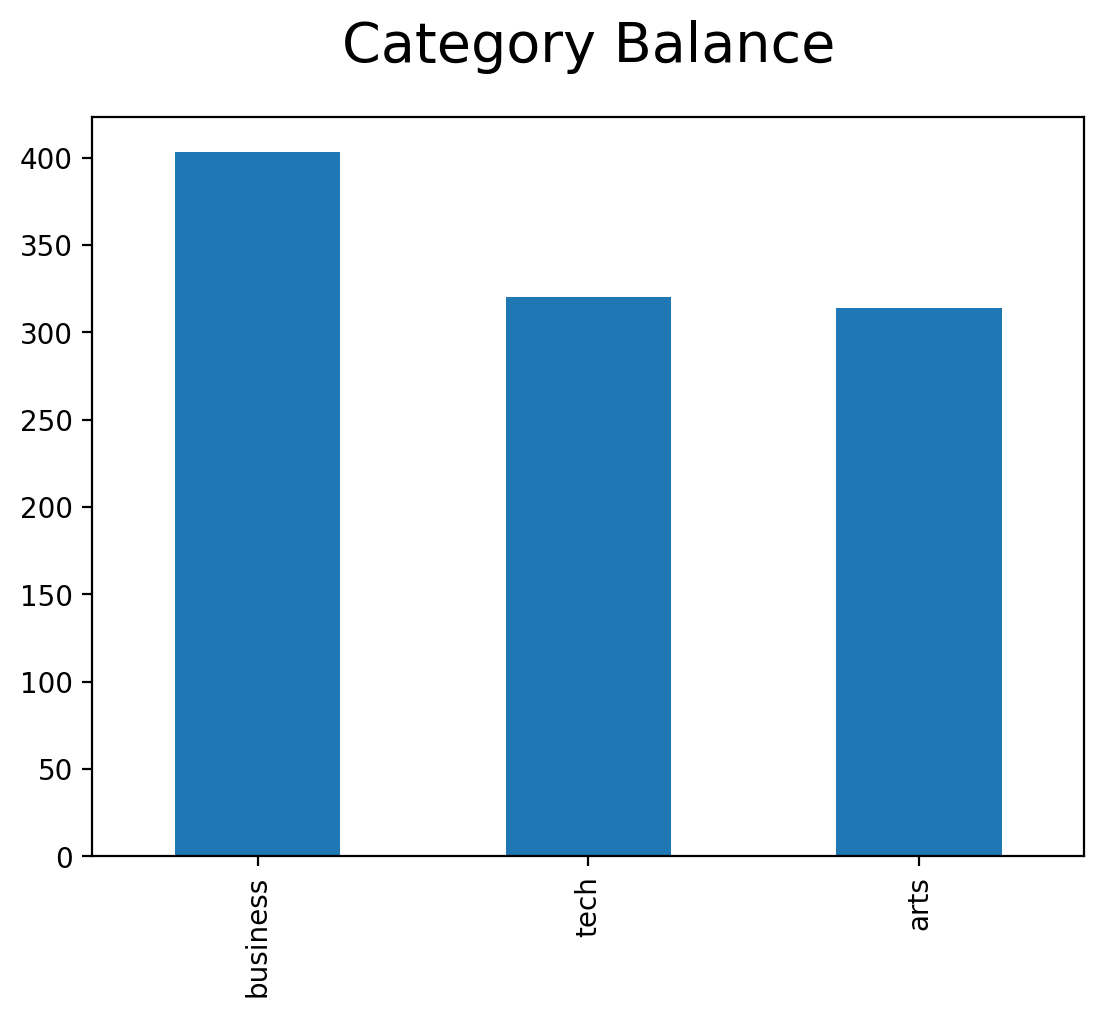

In [18]:
y_train.value_counts().plot(kind='bar')
plt.title('Category Balance', size=20, pad=20);

In [19]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1037,) (260,) (1037,) (260,)


## Vectorize 

In [20]:
vector = TfidfVectorizer(stop_words='english', 
                         ngram_range = (1,2),
                         min_df = 3,
                         max_df = 1.,
                         max_features = 10000)

## Construct Model 

In [21]:
def fit_model(model, model_name):
    line = Pipeline([('vectorize', vector), (model_name, model)])
    
    output = cross_validate(line, 
                            X_train, 
                            y_train, 
                            cv = KFold(shuffle = True, 
                                       n_splits = 3,  
                                       random_state = 9),
                            scoring = ('accuracy', 'f1_weighted','precision_weighted','recall_weighted'),           
                            return_train_score=True)
    return output

In [22]:
dectree = fit_model(DecisionTreeClassifier(), 'DTree')
ridge = fit_model(RidgeClassifier(), 'Ridge')
bayes = fit_model(MultinomialNB(), 'NB')

dt = pd.DataFrame.from_dict(dectree)
rc = pd.DataFrame.from_dict(ridge)
bc = pd.DataFrame.from_dict(bayes)

In [23]:
l1 = [bc, rc, dt]
l2 =["NB", "Ridge", "DT"]

for each, tag in zip(l1, l2):
    each['model'] = [tag, tag, tag]

joined_output = pd.concat([bc,rc,dt])

In [24]:
dectree

{'fit_time': array([1.02936769, 1.0309906 , 1.05870652]),
 'score_time': array([0.18051171, 0.22546077, 0.1838944 ]),
 'test_accuracy': array([0.84971098, 0.86416185, 0.91304348]),
 'train_accuracy': array([1., 1., 1.]),
 'test_f1_weighted': array([0.84925551, 0.86425652, 0.91303867]),
 'train_f1_weighted': array([1., 1., 1.]),
 'test_precision_weighted': array([0.85004804, 0.8644437 , 0.9134893 ]),
 'train_precision_weighted': array([1., 1., 1.]),
 'test_recall_weighted': array([0.84971098, 0.86416185, 0.91304348]),
 'train_recall_weighted': array([1., 1., 1.])}

In [25]:
ridge

{'fit_time': array([0.92781329, 0.84742618, 1.19594932]),
 'score_time': array([0.26566219, 0.26580262, 0.24404383]),
 'test_accuracy': array([0.97398844, 0.97976879, 0.9826087 ]),
 'train_accuracy': array([1., 1., 1.]),
 'test_f1_weighted': array([0.97402024, 0.9797116 , 0.982637  ]),
 'train_f1_weighted': array([1., 1., 1.]),
 'test_precision_weighted': array([0.97412924, 0.98002673, 0.98303811]),
 'train_precision_weighted': array([1., 1., 1.]),
 'test_recall_weighted': array([0.97398844, 0.97976879, 0.9826087 ]),
 'train_recall_weighted': array([1., 1., 1.])}

In [26]:
bayes

{'fit_time': array([0.81527138, 0.79822183, 0.84475279]),
 'score_time': array([0.20574403, 0.18563151, 0.17432261]),
 'test_accuracy': array([0.97687861, 0.9566474 , 0.96811594]),
 'train_accuracy': array([0.99421129, 0.99131693, 0.99566474]),
 'test_f1_weighted': array([0.97693037, 0.95689227, 0.96824353]),
 'train_f1_weighted': array([0.99421129, 0.9913261 , 0.99566425]),
 'test_precision_weighted': array([0.97719738, 0.95881394, 0.96867114]),
 'train_precision_weighted': array([0.99421129, 0.99138305, 0.99569032]),
 'test_recall_weighted': array([0.97687861, 0.9566474 , 0.96811594]),
 'train_recall_weighted': array([0.99421129, 0.99131693, 0.99566474])}

In [27]:
relevant_measures = list(['test_accuracy','test_precision_weighted', 'test_recall_weighted', 'test_f1_weighted'])

dec_tree_metrics = joined_output.loc[joined_output.model == 'DT'][relevant_measures]
nb_metrics = joined_output.loc[joined_output.model == 'NB'][relevant_measures]
r_metrics = joined_output.loc[joined_output.model == 'Ridge'][relevant_measures]

In [28]:
## Decision Tree

In [29]:
dec_tree_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.849711,0.850048,0.849711,0.849256
1,0.864162,0.864444,0.864162,0.864257
2,0.913043,0.913489,0.913043,0.913039


In [30]:
## Multinomial Naiv bayes metrics

In [31]:
nb_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.976879,0.977197,0.976879,0.976930
1,0.956647,0.958814,0.956647,0.956892
2,0.968116,0.968671,0.968116,0.968244


In [32]:
## Ridge Classifier metrics

In [33]:
r_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.973988,0.974129,0.973988,0.974020
1,0.979769,0.980027,0.979769,0.979712
2,0.982609,0.983038,0.982609,0.982637


In [34]:
## Average Metrics

In [35]:
metrics_ = [dec_tree_metrics, nb_metrics, r_metrics]
names_ = ['Decision Tree', 'Naive Bayes', 'Ridge Classifier']

for scores, namess in zip(metrics_, names_):
    print(f'{namess} Mean Metrics:')
    print(scores.mean())
    print('  ')

Decision Tree Mean Metrics:
test_accuracy              0.875639
test_precision_weighted    0.875994
test_recall_weighted       0.875639
test_f1_weighted           0.875517
dtype: float64
  
Naive Bayes Mean Metrics:
test_accuracy              0.967214
test_precision_weighted    0.968227
test_recall_weighted       0.967214
test_f1_weighted           0.967355
dtype: float64
  
Ridge Classifier Mean Metrics:
test_accuracy              0.978789
test_precision_weighted    0.979065
test_recall_weighted       0.978789
test_f1_weighted           0.978790
dtype: float64
  


## Model Selection

In [36]:
# Join training and test datasets
X = pd.concat([X_train, 
               X_test])
y = pd.concat([y_train, 
               y_test])

In [37]:
def create_and_fit(clf, x, y):
    best_clf = clf
    pipeline = Pipeline([('vectorize', vector), ('model', best_clf)])
    return pipeline.fit(x, y)

In [38]:
# Create model
CLASSYfier = create_and_fit(MultinomialNB(), X, y)

In [39]:
CLASSYfier.classes_

array(['arts', 'business', 'tech'], dtype='<U8')

In [40]:
input_text = '(Reuters) -Netflix Inc said it would make a deeper dive into video games as the movie and TV streaming service projected weak subscriber growth amid growing competition and the lifting of pandemic restrictions that had kept people at home.'
CLASSYfier.predict_proba([input_text])

array([[0.15088487, 0.39664897, 0.45246616]])

In [41]:
CLASSYfier.predict([input_text])[0]

'tech'

## GUI

In [42]:
import tkinter as tk
from tkinter.scrolledtext import ScrolledText


window = tk.Tk()


window.title("TEXT CLASSIFIER")
window.minsize(600,400)

text_box = ScrolledText(window)
text_box.grid(column=0, row=1, padx=5, pady=5)

def result(res, pr):
    ARTS = round(pr[0][0], 3)
    BUSINESS = round(pr[0][1], 3)
    TECH = round(pr[0][2], 3)
    
    lines = [f"Arts: {ARTS}", f"Business: {BUSINESS}", f"Tech: {TECH}"]
    tk.messagebox.showinfo(message= f"Predicted Category: {str(res).capitalize()}" + "\n\n\n"+"\n".join(lines))

def clickMe():
    classification = tk.StringVar()
    category_,probabilities = classify_text(text_box.get("1.0",tk.END))
    result(category_, probabilities)
    

def classify_text(input_text):
    out = CLASSYfier.predict([input_text])[0]
    probs = CLASSYfier.predict_proba([input_text])
    return out,probs

label = tk.Label(window, text = "Enter Text to be classified")
label.grid(column = 0, row = 0)

btn = tk.Button(window, text="Classify", command=clickMe)
btn.grid(column=0, row=2)
   



window.mainloop()